In [ ]:
#DCGAN for generating realistic looking waterfall images with image size 64*64*3

In [ ]:
#Dataset is collect by the team and the models are built from scratch

#Loading Libraries

In [ ]:
from zipfile import ZipFile as zp
import os
from PIL import Image 
import numpy as np 
from matplotlib import pyplot
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
print("Eager mode enabled: ", tf.executing_eagerly())
print("TF Version: ", tf.__version__)
print("GPU available: ", tf.config.list_physical_devices('GPU'))

Eager mode enabled:  True
TF Version:  2.7.0
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
file_name = "clean_images.zip"
with zp(file_name, 'r') as zipp:
  zipp.extractall()
  print('Done')

Done


In [ ]:
img = mpimg.imread('clean_images/1154430.jpg')

In [ ]:
img.shape

(1200, 1920, 3)

In [ ]:
im=np.array(Image.open('clean_images/1154430.jpg').resize((64,64)))
im.shape

(64, 64, 3)

In [ ]:
im2=Image.open('clean_images/1154430.jpg').resize((64,64),Image.NEAREST)
im2.size

(64, 64)

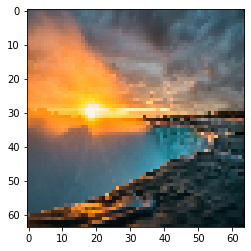

In [ ]:
pyplot.imshow(im2)

pyplot.show()

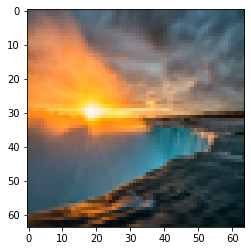

In [ ]:
pyplot.imshow(im)
pyplot.show()

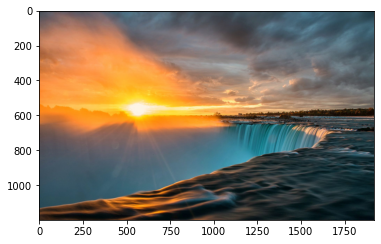

In [ ]:
pyplot.imshow(img)
pyplot.show()

In [ ]:
dir="clean_images/"
images=os.listdir(dir)
image_array=[]
for image in images:
  if (np.array(Image.open(dir+image).resize((64,64),Image.NEAREST))).shape==(64,64,3):
    image_array.append(np.array(Image.open(dir+image).resize((64,64),Image.NEAREST)))
# summarize some details about the image
image_array=np.array(image_array)
print(image_array.shape)

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


(554, 64, 64, 3)


In [ ]:
len(images)

558

In [ ]:
waterfall_norm=(np.array(image_array).astype("float32") / 255)
print(image_array.shape)

(554, 64, 64, 3)


#Generator

In [ ]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 64),
        layers.Reshape((8, 8, 64)),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),   
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2), 
        layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2), 
        layers.Conv2DTranspose(32, kernel_size=4, padding="same"),
        layers.LeakyReLU(alpha=0.2),                
        layers.Conv2D(3, kernel_size=5, padding="same", activation="tanh"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              528384    
                                                                 
 reshape (Reshape)           (None, 8, 8, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 256)      262400    
 nspose)                                                         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      524416    
 ranspose)                                                       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 128)       0 

# Discriminator

In [ ]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(32, kernel_size=4, padding="same"),
        layers.LeakyReLU(alpha=0.2),     
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),    
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        1568      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        32832     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 256)       

#Model creation

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [ ]:
def get_model():
  return GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

Create a folder name Generated_images to save the images in a folder

In [ ]:
os.mkdir("generated_images")

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=1, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        if (epoch + 1) % 50 == 0:
          for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("./generated_images/generated_img_%03d_%d.png" % (epoch, i))

In [ ]:
epochs =500 

gan = get_model()
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0002),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002),
    loss_fn=keras.losses.BinaryCrossentropy(),
)
plotter=GANMonitor()
checkpoint_filepath = "./model_checkpoints/dcgan_checkpoints.{epoch:01d}"
checkpoint_dir= os.path.dirname(checkpoint_filepath)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                               save_weights_only=True, period=5)

gan.fit(
    waterfall_norm, epochs=epochs, callbacks=[plotter,model_checkpoint_callback], batch_size=32
)


**Note:** the console to show the epochs running and zip file creating is removed as it will take extra pages in the pdf

#Creating a zip file of created images

In [ ]:
! zip generated.zip *.png

#To save model weights

In [ ]:
gan.save_weights('path_to_my_weights', save_format='tf')  

In [ ]:
im3=Image.open('generated_img_129_9.png').resize((256,256),Image.NEAREST)
im3.size

(256, 256)

In [ ]:
#Example of an image created by the model

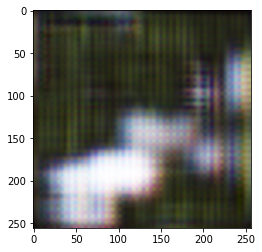

In [ ]:
pyplot.imshow(im3)

pyplot.show()